# Setup

In [94]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [95]:
import os

In [96]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '..')

In [97]:
sys.path.remove('/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages')
sys.path.append('/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages')

In [98]:
import json
import glob
from utils.metrics import extract_metrics_config, Metric

# Load metrics

In [99]:
file_list = glob.glob('./experiments/configs/*amazon*.json')

configs = [json.load(open(file)) for file in file_list]

In [100]:
# add prefix to path

for config in configs:
    config["model"]["training"][
        "log_dir"] = "experiments/" + config["model"]["training"]["log_dir"]

In [101]:
metrics = [Metric(**extract_metrics_config(config)) for config in configs]

# ROC Curve

[[<matplotlib.lines.Line2D at 0x14b9f40d64c0>],

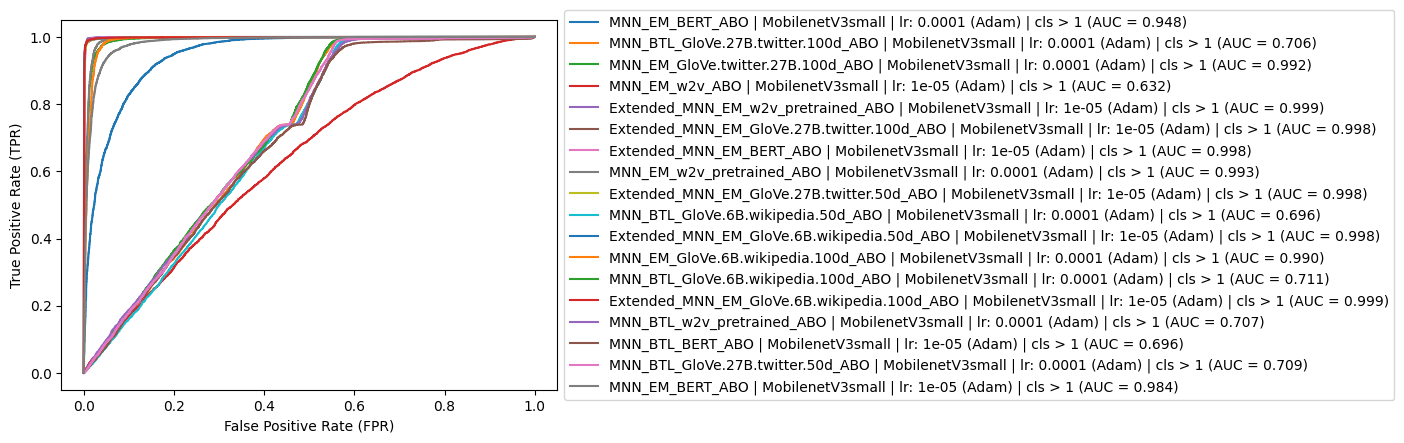

In [102]:
[metric.plot_roc() for metric in metrics]

# Precision-Recall Curve (PRC)

[[<matplotlib.lines.Line2D at 0x14b9f5ad6700>],

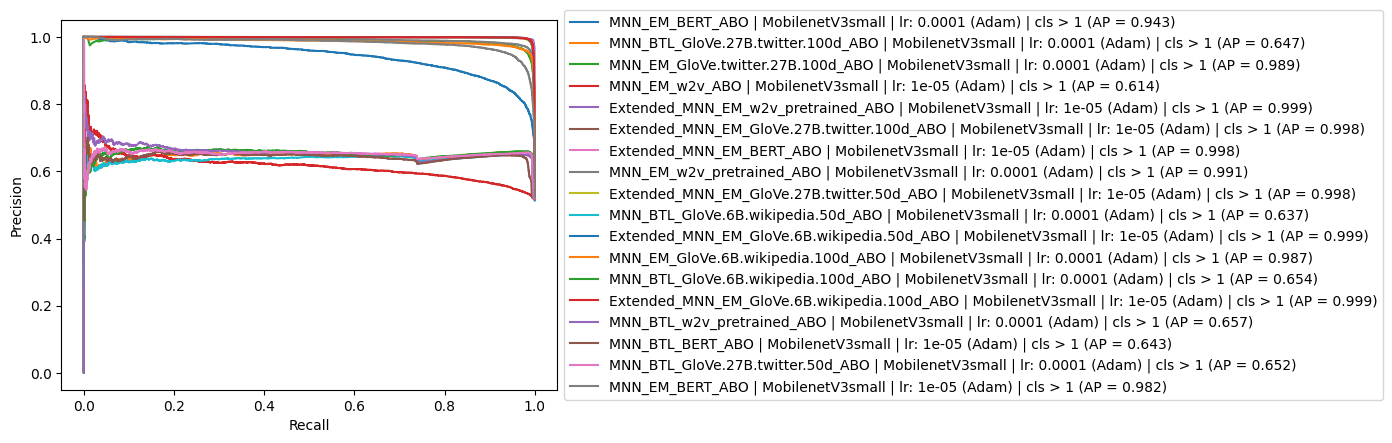

In [103]:
[metric.plot_prc() for metric in metrics]

# Optimal accuracy

The `optimize_threshold()` method calculates and outputs optimal threshold for ROC curve using G-Mean and Youden-Index/J, as well as the optimal threshold for Precision-Recall curve using F-Score.

See also https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [104]:
import pandas as pd

## Merge with original paper results

In [105]:
paths = []

for root, dirs, files in os.walk("../runs"):
    for f in files:
        if f == "metrics.npy":
            paths.append(root + "/" + f)
        

paper_configs = []

for path in paths:
    path = path.split("/")
    if len(path) == 9:
        paper_configs.append({
            "log_dir": "/".join(path[0:2]),
            "model_name": path[3],
            "img_model_name": path[5],
            "optimizer_name": path[6],
            "learning_rate": path[7].split("lr_")[1],
            "cls": path[4].split("_")[1]
        })
    else:
        paper_configs.append({
            "log_dir": "/".join(path[0:2]),
            "model_name": path[3],
            "img_model_name": ".",
            "optimizer_name": path[5],
            "learning_rate": path[6].split("lr_")[1],
            "cls": path[4].split("_")[1]
        })

paper_metrics = [Metric(**config) for config in paper_configs]
metrics += paper_metrics

In [106]:
metrics_df = pd.DataFrame.from_dict(
    [metric.optimize_threshold() for metric in metrics])

In [107]:
# select metrics relevant for paper
metrics_df = metrics_df[["Model name", "Image CNN", "# Parameters (without Image CNN)", "Total parameters", "lr", "AUC-ROC", "AUC-PRC", "Precision", "Recall", "F-Score", "Threshold F-Score", "Accuracy F-Score"]]
metrics_df["lr"] = metrics_df["lr"].astype(float)

# Apply styling to the DataFrame
style = {
    '# Parameters (without Image CNN)': lambda x: f'{x/1e6:.1f} M' if x >= 1e6 else f'{x/1e3:.1f} K',
    'Total parameters': lambda x: f'{x/1e6:.1f} M' if x >= 1e6 else f'{x/1e3:.1f} K',
    'lr': '{:.5g}',
    'AUC-ROC': '{:.4f}',
    'AUC-PRC': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F-Score': '{:.4f}',
    'Threshold F-Score': '{:.4f}',
    'Accuracy F-Score': '{:.2%}'
}

# All models ranked by Accuracy

In [108]:
pd.set_option('display.max_rows', len(metrics_df))

In [109]:
metrics_df.sort_values(by="Accuracy F-Score", ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
107,Siamaese_Char_MLSTM_Falzone_ABO,.,70.7 K,70.7 K,0.01,0.9999,0.9999,0.9998,1.0000,0.9999,1.0000,99.99%
4,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,285.0 M,285.9 M,1e-05,0.9991,0.9991,0.9912,0.9959,0.9935,0.8858,99.32%
44,Extended_MNN_EM_ABO,MobilenetV3small,19.7 M,20.6 M,1e-05,0.9944,0.9900,0.9823,0.9997,0.9909,0.6908,99.08%
13,Extended_MNN_EM_GloVe.6B.wikipedia.100d_ABO,MobilenetV3small,55.4 M,56.3 M,1e-05,0.9985,0.9987,0.9917,0.9902,0.9909,0.8534,99.05%
6,Extended_MNN_EM_BERT_ABO,MobilenetV3small,28.1 M,29.0 M,1e-05,0.9980,0.9980,0.9880,0.9940,0.9910,0.8321,99.04%
42,Extended_MNN_EM_ABO,MobilenetV3large,19.7 M,22.7 M,1e-05,0.9942,0.9898,0.9815,0.9992,0.9903,0.6924,99.00%
43,Extended_MNN_EM_ABO,vgg19,19.7 M,39.7 M,1e-05,0.9939,0.9885,0.9805,0.9994,0.9899,0.7608,98.98%
10,Extended_MNN_EM_GloVe.6B.wikipedia.50d_ABO,MobilenetV3small,23.6 M,24.5 M,1e-05,0.9982,0.9986,0.9897,0.9902,0.9899,0.6806,98.96%
5,Extended_MNN_EM_GloVe.27B.twitter.100d_ABO,MobilenetV3small,55.4 M,56.3 M,1e-05,0.9981,0.9983,0.9914,0.9858,0.9886,0.7757,98.81%
8,Extended_MNN_EM_GloVe.27B.twitter.50d_ABO,MobilenetV3small,23.6 M,24.5 M,1e-05,0.9980,0.9984,0.9893,0.9877,0.9885,0.8468,98.80%


# All models ranked by # of parameters

In [110]:
metrics_df.sort_values(by="Total parameters", ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
4,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,285.0 M,285.9 M,1e-05,0.9991,0.9991,0.9912,0.9959,0.9935,0.8858,99.32%
7,MNN_EM_w2v_pretrained_ABO,MobilenetV3small,143.5 M,144.4 M,0.0001,0.9931,0.9912,0.9680,0.9845,0.9762,0.6391,97.48%
14,MNN_BTL_w2v_pretrained_ABO,MobilenetV3small,143.1 M,144.0 M,0.0001,0.7069,0.6575,0.6480,0.9844,0.7816,-0.3645,71.41%
119,Extended_MNN_EM_ABO_random_deletion,resnet152,19.7 M,78.0 M,0.0001,0.9837,0.9803,0.9350,0.9801,0.9570,0.2238,95.52%
118,Extended_MNN_EM_ABO_random_deletion,resnet152,19.7 M,78.0 M,5e-05,0.9826,0.9788,0.9274,0.9828,0.9543,0.2108,95.20%
104,Extended_MNN_EM_ABO_random_deletion_augmented,resnet152,19.7 M,78.0 M,1e-05,0.9925,0.9899,0.9554,0.9855,0.9702,0.4205,96.93%
105,Extended_MNN_EM_ABO_random_deletion_augmented,resnet152,19.7 M,78.0 M,5e-05,0.9942,0.9931,0.9670,0.9884,0.9776,0.5238,97.70%
106,Extended_MNN_EM_ABO_random_deletion_augmented,resnet152,19.7 M,78.0 M,0.0001,0.9947,0.9934,0.9667,0.9909,0.9787,0.4810,97.81%
117,Extended_MNN_EM_ABO_random_deletion,resnet152,19.7 M,78.0 M,1e-05,0.9765,0.9721,0.9132,0.9689,0.9402,0.3004,93.73%
45,Extended_MNN_EM_ABO,resnet152,19.7 M,78.0 M,1e-05,0.9918,0.9843,0.9777,0.9981,0.9878,0.6878,98.79%


# MNN-EM

In [111]:
metrics_df[metrics_df["Model name"].str.startswith("MNN_EM")].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
74,MNN_EM_ABO,vgg19,17.6 M,37.6 M,0.0005,0.9853,0.9740,0.9542,0.9876,0.9706,0.5844,96.92%
76,MNN_EM_ABO,vgg19,17.6 M,37.6 M,0.0001,0.9904,0.9880,0.9541,0.9854,0.9695,0.3073,96.81%
75,MNN_EM_ABO,vgg19,17.6 M,37.6 M,0.001,0.9863,0.9814,0.9480,0.9824,0.9649,0.5092,96.32%
21,MNN_EM_ABO_random_deletion_augmented,vgg19,17.6 M,37.6 M,0.0005,0.9690,0.9607,0.8937,0.9624,0.9268,0.4921,92.29%
23,MNN_EM_ABO_random_deletion_augmented,vgg19,17.6 M,37.6 M,0.0001,0.9680,0.9594,0.8897,0.9671,0.9268,0.4562,92.25%
64,MNN_EM_ABO_random_deletion,vgg19,17.6 M,37.6 M,0.0001,0.9441,0.9291,0.8574,0.9455,0.8993,0.3959,89.23%
63,MNN_EM_ABO_random_deletion,vgg19,17.6 M,37.6 M,0.001,0.9369,0.9233,0.8154,0.9721,0.8869,0.3366,87.39%
62,MNN_EM_ABO_random_deletion,vgg19,17.6 M,37.6 M,0.0005,0.9240,0.8999,0.8009,0.9732,0.8787,0.3928,86.33%
22,MNN_EM_ABO_random_deletion_augmented,vgg19,17.6 M,37.6 M,0.001,0.6557,0.6108,0.5828,0.8664,0.6968,0.3610,61.81%
80,MNN_EM_ABO,resnet152,17.6 M,75.9 M,0.0005,0.9901,0.9856,0.9595,0.9860,0.9726,0.4630,97.14%


# Extended MNN-EM

In [112]:
metrics_df[metrics_df["Model name"].str.startswith("Extended_MNN_EM")].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
43,Extended_MNN_EM_ABO,vgg19,19.7 M,39.7 M,1e-05,0.9939,0.9885,0.9805,0.9994,0.9899,0.7608,98.98%
99,Extended_MNN_EM_ABO_random_deletion_augmented,vgg19,19.7 M,39.7 M,5e-05,0.9944,0.9932,0.9641,0.9910,0.9773,0.4094,97.67%
98,Extended_MNN_EM_ABO_random_deletion_augmented,vgg19,19.7 M,39.7 M,1e-05,0.9929,0.9914,0.9542,0.9860,0.9698,0.3854,96.89%
100,Extended_MNN_EM_ABO_random_deletion_augmented,vgg19,19.7 M,39.7 M,0.0001,0.9925,0.9913,0.9506,0.9842,0.9671,0.2116,96.61%
113,Extended_MNN_EM_ABO_random_deletion,vgg19,19.7 M,39.7 M,0.0001,0.9833,0.9793,0.9323,0.9870,0.9589,0.2182,95.69%
112,Extended_MNN_EM_ABO_random_deletion,vgg19,19.7 M,39.7 M,5e-05,0.9845,0.9819,0.9242,0.9825,0.9524,0.2003,95.01%
111,Extended_MNN_EM_ABO_random_deletion,vgg19,19.7 M,39.7 M,1e-05,0.9791,0.9758,0.9202,0.9601,0.9397,0.4045,93.73%
45,Extended_MNN_EM_ABO,resnet152,19.7 M,78.0 M,1e-05,0.9918,0.9843,0.9777,0.9981,0.9878,0.6878,98.79%
106,Extended_MNN_EM_ABO_random_deletion_augmented,resnet152,19.7 M,78.0 M,0.0001,0.9947,0.9934,0.9667,0.9909,0.9787,0.4810,97.81%
105,Extended_MNN_EM_ABO_random_deletion_augmented,resnet152,19.7 M,78.0 M,5e-05,0.9942,0.9931,0.9670,0.9884,0.9776,0.5238,97.70%


# MNN-BTL

In [113]:
metrics_df[metrics_df["Model name"].str.startswith("MNN_BTL")].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
87,MNN_BTL_ABO,vgg19,17.2 M,37.2 M,0.001,0.9255,0.9431,0.9866,0.7414,0.8466,-0.3382,86.06%
52,MNN_BTL_ABO_random_deletion,vgg19,17.2 M,37.2 M,0.0001,0.8498,0.8110,0.6997,0.9078,0.7903,-0.4314,75.71%
86,MNN_BTL_ABO,vgg19,17.2 M,37.2 M,0.0005,0.8316,0.7702,0.6806,0.9924,0.8075,-0.3827,75.45%
88,MNN_BTL_ABO,vgg19,17.2 M,37.2 M,0.0001,0.8389,0.7882,0.6796,0.9961,0.8080,-0.3825,75.44%
35,MNN_BTL_ABO_random_deletion_augmented,vgg19,17.2 M,37.2 M,0.0001,0.8586,0.8531,0.6673,0.9460,0.7826,-0.4649,73.45%
34,MNN_BTL_ABO_random_deletion_augmented,vgg19,17.2 M,37.2 M,0.001,0.6831,0.6733,0.6271,0.9859,0.7666,-0.0178,69.67%
50,MNN_BTL_ABO_random_deletion,vgg19,17.2 M,37.2 M,0.0005,0.6241,0.5903,0.5116,0.9735,0.6708,-1.0000,51.83%
51,MNN_BTL_ABO_random_deletion,vgg19,17.2 M,37.2 M,0.001,0.6303,0.5941,0.5071,0.9928,0.6713,-0.9999,51.00%
33,MNN_BTL_ABO_random_deletion_augmented,vgg19,17.2 M,37.2 M,0.0005,0.6287,0.6016,0.5053,0.9996,0.6713,-1.0000,50.54%
93,MNN_BTL_ABO,resnet152,17.2 M,75.5 M,0.001,0.9084,0.9250,0.9439,0.7250,0.8201,1.0000,83.50%


# Siamese Char-level MLSTM

In [114]:
metrics_df[metrics_df["Model name"].str.startswith("Siamaese")].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
107,Siamaese_Char_MLSTM_Falzone_ABO,.,70.7 K,70.7 K,0.01,0.9999,0.9999,0.9998,1.0000,0.9999,1.0000,99.99%
46,Siamaese_Char_MLSTM_Falzone_ABO_random_deletion,.,70.7 K,70.7 K,0.01,0.6295,0.7346,0.5056,1.0000,0.6716,0.4062,50.74%


# Word2Vec vs Char-CNN (ours)

We compare against Word2Vec embeddings with and without pretraining.

We obtained the pretrained word embeddings from: https://huggingface.co/fse/word2vec-google-news-300

Because the pretrained embeddings are 300-dimensional, the # of parameters are 10-20x higher than our character-based models!

In [115]:
metrics_df[(metrics_df["Model name"].str.contains("w2v")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
4,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,285.0 M,285.9 M,1e-05,0.9991,0.9991,0.9912,0.9959,0.9935,0.8858,99.32%
44,Extended_MNN_EM_ABO,MobilenetV3small,19.7 M,20.6 M,1e-05,0.9944,0.9900,0.9823,0.9997,0.9909,0.6908,99.08%
7,MNN_EM_w2v_pretrained_ABO,MobilenetV3small,143.5 M,144.4 M,0.0001,0.9931,0.9912,0.9680,0.9845,0.9762,0.6391,97.48%
77,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0005,0.9900,0.9861,0.9545,0.9860,0.9700,0.5343,96.86%
79,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0001,0.9885,0.9825,0.9582,0.9799,0.9689,0.4393,96.76%
78,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.001,0.9855,0.9785,0.9513,0.9799,0.9654,0.5706,96.38%
89,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.0005,0.8538,0.8149,0.7089,0.9456,0.8103,-0.4086,77.03%
91,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.0001,0.8356,0.7856,0.6851,0.9814,0.8069,-0.3632,75.64%
90,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.001,0.8363,0.7876,0.6828,0.9865,0.8070,-0.3583,75.53%
14,MNN_BTL_w2v_pretrained_ABO,MobilenetV3small,143.1 M,144.0 M,0.0001,0.7069,0.6575,0.6480,0.9844,0.7816,-0.3645,71.41%


In [116]:
print(metrics_df[(metrics_df["Model name"].str.contains("w2v")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)
      .to_latex())

\begin{tabular}{lllrrrrrrrrrr}
 & Model name & Image CNN & # Parameters (without Image CNN) & Total parameters & lr & AUC-ROC & AUC-PRC & Precision & Recall & F-Score & Threshold F-Score & Accuracy F-Score \\
4 & Extended_MNN_EM_w2v_pretrained_ABO & MobilenetV3small & 285.0 M & 285.9 M & 1e-05 & 0.9991 & 0.9991 & 0.9912 & 0.9959 & 0.9935 & 0.8858 & 99.32% \\
44 & Extended_MNN_EM_ABO & MobilenetV3small & 19.7 M & 20.6 M & 1e-05 & 0.9944 & 0.9900 & 0.9823 & 0.9997 & 0.9909 & 0.6908 & 99.08% \\
7 & MNN_EM_w2v_pretrained_ABO & MobilenetV3small & 143.5 M & 144.4 M & 0.0001 & 0.9931 & 0.9912 & 0.9680 & 0.9845 & 0.9762 & 0.6391 & 97.48% \\
77 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.0005 & 0.9900 & 0.9861 & 0.9545 & 0.9860 & 0.9700 & 0.5343 & 96.86% \\
79 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.0001 & 0.9885 & 0.9825 & 0.9582 & 0.9799 & 0.9689 & 0.4393 & 96.76% \\
78 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.001 & 0.9855 & 0.9785 & 0.9513 & 0.9799 & 0.96

# GloVe vs Char-CNN (ours)

We obtain the GloVe embeddings from: https://nlp.stanford.edu/projects/glove/

We only choose the embeddings trained on:
* Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d and 100d vectors),
* Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 50d and 100d vectors),

since the # of parameters is the closest to our models.

Even though the # of parameters isn't as high as Word2Vec, since we only use 50/100-dimensional embeddings, it is still 2-3x higher than our models.

In [117]:
metrics_df[(metrics_df["Model name"].str.contains("GloVe")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
44,Extended_MNN_EM_ABO,MobilenetV3small,19.7 M,20.6 M,1e-05,0.9944,0.9900,0.9823,0.9997,0.9909,0.6908,99.08%
13,Extended_MNN_EM_GloVe.6B.wikipedia.100d_ABO,MobilenetV3small,55.4 M,56.3 M,1e-05,0.9985,0.9987,0.9917,0.9902,0.9909,0.8534,99.05%
10,Extended_MNN_EM_GloVe.6B.wikipedia.50d_ABO,MobilenetV3small,23.6 M,24.5 M,1e-05,0.9982,0.9986,0.9897,0.9902,0.9899,0.6806,98.96%
5,Extended_MNN_EM_GloVe.27B.twitter.100d_ABO,MobilenetV3small,55.4 M,56.3 M,1e-05,0.9981,0.9983,0.9914,0.9858,0.9886,0.7757,98.81%
8,Extended_MNN_EM_GloVe.27B.twitter.50d_ABO,MobilenetV3small,23.6 M,24.5 M,1e-05,0.9980,0.9984,0.9893,0.9877,0.9885,0.8468,98.80%
11,MNN_EM_GloVe.6B.wikipedia.100d_ABO,MobilenetV3small,28.7 M,29.6 M,0.0001,0.9898,0.9865,0.9559,0.9853,0.9704,0.3100,96.88%
77,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0005,0.9900,0.9861,0.9545,0.9860,0.9700,0.5343,96.86%
79,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0001,0.9885,0.9825,0.9582,0.9799,0.9689,0.4393,96.76%
2,MNN_EM_GloVe.twitter.27B.100d_ABO,MobilenetV3small,28.7 M,29.6 M,0.0001,0.9915,0.9889,0.9639,0.9744,0.9691,0.5333,96.76%
78,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.001,0.9855,0.9785,0.9513,0.9799,0.9654,0.5706,96.38%


In [118]:
print(metrics_df[(metrics_df["Model name"].str.contains("GloVe")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)
      .to_latex())

\begin{tabular}{lllrrrrrrrrrr}
 & Model name & Image CNN & # Parameters (without Image CNN) & Total parameters & lr & AUC-ROC & AUC-PRC & Precision & Recall & F-Score & Threshold F-Score & Accuracy F-Score \\
44 & Extended_MNN_EM_ABO & MobilenetV3small & 19.7 M & 20.6 M & 1e-05 & 0.9944 & 0.9900 & 0.9823 & 0.9997 & 0.9909 & 0.6908 & 99.08% \\
13 & Extended_MNN_EM_GloVe.6B.wikipedia.100d_ABO & MobilenetV3small & 55.4 M & 56.3 M & 1e-05 & 0.9985 & 0.9987 & 0.9917 & 0.9902 & 0.9909 & 0.8534 & 99.05% \\
10 & Extended_MNN_EM_GloVe.6B.wikipedia.50d_ABO & MobilenetV3small & 23.6 M & 24.5 M & 1e-05 & 0.9982 & 0.9986 & 0.9897 & 0.9902 & 0.9899 & 0.6806 & 98.96% \\
5 & Extended_MNN_EM_GloVe.27B.twitter.100d_ABO & MobilenetV3small & 55.4 M & 56.3 M & 1e-05 & 0.9981 & 0.9983 & 0.9914 & 0.9858 & 0.9886 & 0.7757 & 98.81% \\
8 & Extended_MNN_EM_GloVe.27B.twitter.50d_ABO & MobilenetV3small & 23.6 M & 24.5 M & 1e-05 & 0.9980 & 0.9984 & 0.9893 & 0.9877 & 0.9885 & 0.8468 & 98.80% \\
11 & MNN_EM_GloVe.6B.

# BERT vs Char-CNN (ours)

We obtain the BERT model from: https://tfhub.dev/google/collections/bert/1

Due to hardware limitations, we only use `small_bert/bert_en_uncased_L-6_H-256_A-4` with:
* L=6 (Layers)
* H=256 (Hidden size)
* A=4 (Attention heads)

The # of parameters closely match our models.

In [119]:
metrics_df[(metrics_df["Model name"].str.contains("BERT")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)

,Model name,Image CNN,# Parameters (without Image CNN),Total parameters,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
44,Extended_MNN_EM_ABO,MobilenetV3small,19.7 M,20.6 M,1e-05,0.9944,0.9900,0.9823,0.9997,0.9909,0.6908,99.08%
6,Extended_MNN_EM_BERT_ABO,MobilenetV3small,28.1 M,29.0 M,1e-05,0.9980,0.9980,0.9880,0.9940,0.9910,0.8321,99.04%
77,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0005,0.9900,0.9861,0.9545,0.9860,0.9700,0.5343,96.86%
79,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.0001,0.9885,0.9825,0.9582,0.9799,0.9689,0.4393,96.76%
78,MNN_EM_ABO,MobilenetV3small,17.6 M,18.5 M,0.001,0.9855,0.9785,0.9513,0.9799,0.9654,0.5706,96.38%
17,MNN_EM_BERT_ABO,MobilenetV3small,15.1 M,16.0 M,1e-05,0.9838,0.9815,0.9402,0.9573,0.9486,0.5350,94.58%
0,MNN_EM_BERT_ABO,MobilenetV3small,15.1 M,16.0 M,0.0001,0.9477,0.9426,0.8513,0.9362,0.8917,0.0208,88.13%
89,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.0005,0.8538,0.8149,0.7089,0.9456,0.8103,-0.4086,77.03%
91,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.0001,0.8356,0.7856,0.6851,0.9814,0.8069,-0.3632,75.64%
90,MNN_BTL_ABO,MobilenetV3small,17.2 M,18.1 M,0.001,0.8363,0.7876,0.6828,0.9865,0.8070,-0.3583,75.53%


In [120]:
print(metrics_df[(metrics_df["Model name"].str.contains("BERT")) | (metrics_df["Model name"].isin(["MNN_EM_ABO", "Extended_MNN_EM_ABO", "MNN_BTL_ABO"]) & (metrics_df["Image CNN"] == "MobilenetV3small"))].sort_values(by=["Image CNN", "Accuracy F-Score"], ascending=False).style.format(style)
      .to_latex())

\begin{tabular}{lllrrrrrrrrrr}
 & Model name & Image CNN & # Parameters (without Image CNN) & Total parameters & lr & AUC-ROC & AUC-PRC & Precision & Recall & F-Score & Threshold F-Score & Accuracy F-Score \\
44 & Extended_MNN_EM_ABO & MobilenetV3small & 19.7 M & 20.6 M & 1e-05 & 0.9944 & 0.9900 & 0.9823 & 0.9997 & 0.9909 & 0.6908 & 99.08% \\
6 & Extended_MNN_EM_BERT_ABO & MobilenetV3small & 28.1 M & 29.0 M & 1e-05 & 0.9980 & 0.9980 & 0.9880 & 0.9940 & 0.9910 & 0.8321 & 99.04% \\
77 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.0005 & 0.9900 & 0.9861 & 0.9545 & 0.9860 & 0.9700 & 0.5343 & 96.86% \\
79 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.0001 & 0.9885 & 0.9825 & 0.9582 & 0.9799 & 0.9689 & 0.4393 & 96.76% \\
78 & MNN_EM_ABO & MobilenetV3small & 17.6 M & 18.5 M & 0.001 & 0.9855 & 0.9785 & 0.9513 & 0.9799 & 0.9654 & 0.5706 & 96.38% \\
17 & MNN_EM_BERT_ABO & MobilenetV3small & 15.1 M & 16.0 M & 1e-05 & 0.9838 & 0.9815 & 0.9402 & 0.9573 & 0.9486 & 0.5350 & 94.58% \\
